# Drawing wiring diagrams in Compose.jl


Catlab can draw wiring diagrams using the Julia package
[Compose.jl](https://github.com/GiovineItalia/Compose.jl).

For best results, it is recommended to load the packages
[Convex.j](https://github.com/JuliaOpt/Convex.jl) and
[SCS.jl](https://github.com/JuliaOpt/SCS.jl). When available they are used to
optimize the layout of the outer ports.

In [1]:
using Catlab.WiringDiagrams, Catlab.Graphics

import Convex, SCS

## Examples

### Symmetric monoidal category

In [2]:
using Catlab.Theories

A, B, C, D = Ob(FreeSymmetricMonoidalCategory, :A, :B, :C, :D)
f, g = Hom(:f, A, B), Hom(:g, B, A);

To start, here are a few very simple examples.

In [3]:
to_composejl(f)

In [4]:
to_composejl(f⋅g)

In [5]:
to_composejl(f⊗g)

Here is a more complex example, involving generators with compound domains and
codomains.

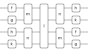

In [6]:
h, k = Hom(:h, C, D),  Hom(:k, D, C)
m, n = Hom(:m, B⊗A, A⊗B), Hom(:n, D⊗C, C⊗D)
q = Hom(:l, A⊗B⊗C⊗D, D⊗C⊗B⊗A)

to_composejl((f⊗g⊗h⊗k)⋅(m⊗n)⋅q⋅(n⊗m)⋅(h⊗k⊗f⊗g))

Identities and braidings appear as wires.

In [7]:
to_composejl(id(A))

In [8]:
to_composejl(braid(A,B))

In [9]:
to_composejl(braid(A,B) ⋅ (g⊗f) ⋅ braid(A,B))

The isomorphism $A \otimes B \otimes C \to C \otimes B \otimes A$ induced by
the permutation $(3\ 2\ 1)$ is a composite of braidings and identities.

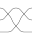

In [10]:
σ = (braid(A,B) ⊗ id(C)) ⋅ (id(B) ⊗ braid(A,C) ⋅ (braid(B,C) ⊗ id(A)))

to_composejl(σ)

By default, anchor points are added along identity and braiding wires to
reproduce the expression structure in the layout. The anchors can be disabled
to get a more "unbiased" layout.

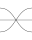

In [11]:
to_composejl(σ, anchor_wires=false)

### Biproduct category

In [12]:
A, B, C = Ob(FreeBiproductCategory, :A, :B, :C)
f = Hom(:f, A, B)

to_composejl(mcopy(A))

In [13]:
to_composejl(delete(A))

In [14]:
to_composejl(mcopy(A)⋅(f⊗f)⋅mmerge(B))

In [15]:
to_composejl(mcopy(A⊗B), orientation=TopToBottom)

In [16]:
to_composejl(mcopy(A⊗B⊗C), orientation=TopToBottom)

### Compact closed category

The unit and co-unit of a compact closed category appear as caps and cups.

In [17]:
A, B = Ob(FreeCompactClosedCategory, :A, :B)

to_composejl(dunit(A))

In [18]:
to_composejl(dcounit(A))

In a self-dual compact closed category, such as a bicategory of relations,
every morphism $f: A \to B$ has a transpose $f^\dagger: B \to A$ given by
bending wires:

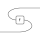

In [19]:
A, B = Ob(FreeBicategoryRelations, :A, :B)
f = Hom(:f, A, B)

to_composejl((dunit(A) ⊗ id(B)) ⋅ (id(A) ⊗ f ⊗ id(B)) ⋅ (id(A) ⊗ dcounit(B)))

### Abelian bicategory of relations

In an abelian bicategory of relations, such as the category of linear
relations, the duplication morphisms $\Delta_X: X \to X \oplus X$ and addition
morphisms $\blacktriangledown_X: X \oplus X \to X$ belong to a bimonoid. Among
other things, this means that the following two morphisms are equal.

In [20]:
X = Ob(FreeAbelianBicategoryRelations, :X)

to_composejl(plus(X) ⋅ mcopy(X))

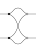

In [21]:
to_composejl((mcopy(X)⊕mcopy(X)) ⋅ (id(X)⊕swap(X,X)⊕id(X)) ⋅ (plus(X)⊕plus(X)))

## Custom styles

The visual appearance of wiring diagrams can be customized by passing Compose
[properties](http://giovineitalia.github.io/Compose.jl/latest/gallery/properties/).

In [22]:
using Compose: fill, stroke

A, B, = Ob(FreeSymmetricMonoidalCategory, :A, :B)
f, g = Hom(:f, A, B), Hom(:g, B, A)

to_composejl(f⋅g, props=Dict(
  :box => [fill("lavender"), stroke("black")],
))

In [23]:
X = Ob(FreeAbelianBicategoryRelations, :X)

to_composejl(plus(X) ⋅ mcopy(X), props=Dict(
  :junction => [fill("red"), stroke("black")],
  :variant_junction => [fill("blue"), stroke("black")],
))

The background color can also be changed.

In [24]:
to_composejl(f⋅g, background_color="lightgray", props=Dict(
  :box => [fill("white"), stroke("black")],
))

By default, the boxes are rectangular (`:rectangle`). Other available shapes
include circles (`:circle`) and ellipses (`:ellipse`).

In [25]:
to_composejl(f⋅g, default_box_shape=:circle)

## Output formats

The function `to_composejl` returns a `ComposePicture` object, which contains
a Compose.jl context as well as a recommended width and height. When displayed
interactively, this object is rendered using Compose's SVG backend.

Any backend can be used by calling Compose's `draw` function. The SVG and
[PGF](https://ctan.org/pkg/pgf) (LaTeX) backends are always available. To use
the PNG or PDF backends, the extra packages
[Cairo.jl](https://github.com/JuliaGraphics/Cairo.jl) and
[Fontconfig.jl](https://github.com/JuliaGraphics/Fontconfig.jl) must be
installed.

For example, here is how to use the PGF backend.

In [26]:
using Compose: draw, PGF

pic = to_composejl(f⋅g, rounded_boxes=false)
pgf = sprint() do io
  pgf_backend = PGF(io, pic.width, pic.height,
    false, # emit_on_finish
    true,  # only_tikz
    texfonts=true)
  draw(pgf_backend, pic.context)
end
println(pgf)

\begin{tikzpicture}[x=1mm,y=-1mm]
\definecolor{mycolor000000}{rgb}{0,0,0}
\begin{scope}
\path [fill=mycolor000000,draw=mycolor000000] (32,8) .. controls (36,8) and (36,8) .. (40,8);
\end{scope}
\begin{scope}
\path [fill=mycolor000000,draw=mycolor000000] (16,8) .. controls (20,8) and (20,8) .. (24,8);
\end{scope}
\begin{scope}
\path [fill=mycolor000000,draw=mycolor000000] (0,8) .. controls (4,8) and (4,8) .. (8,8);
\end{scope}
\begin{scope}
\path [fill=mycolor000000,fill opacity=0,draw=mycolor000000] (24,4) rectangle +(8,8);
\end{scope}
\begin{scope}
\draw (28,8) node [text=mycolor000000,rotate around={-0: (0,0)},inner sep=0.0]{\fontsize{12mm}{14.4mm}\selectfont $\text{g}$};
\end{scope}
\begin{scope}
\path [fill=mycolor000000,fill opacity=0,draw=mycolor000000] (8,4) rectangle +(8,8);
\end{scope}
\begin{scope}
\draw (12,8) node [text=mycolor000000,rotate around={-0: (0,0)},inner sep=0.0]{\fontsize{12mm}{14.4mm}\selectfont $\text{f}$};
\end{scope}
\end{tikzpicture}

